# Determining the Boltzmann Constant using Brownian Motion Analysis
### A portion of the code used throughout this worksheet was taken from the walkthrough for trackpy found at https://soft-matter.github.io/trackpy/v0.3.2/tutorial/walkthrough.html#Locate-features-in-all-frames

In [1]:
import qexpy as q
import trackpy as tp
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pims
import imageio

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mp.rc('figure',  figsize=(10, 6))
mp.rc('image', cmap='gray')

Loading BokehJS ...

### Step 1. Importing the data

In [2]:
frames = pims.Video('BrownianMotionVideos/BrownianMotionPhoneVideo.MOV') # Imports the collected video.
frames # Displays the collected information on the imported video. Individual frames can be accessed through frames[n].

<Frames>
Length: 935 frames
Frame Shape: 1080 x 1920
Pixel Datatype: uint8

Frame([[[102,  94, 101],
        [102,  94, 101],
        [102,  94, 101],
        ..., 
        [ 43,  46,  61],
        [ 41,  44,  59],
        [ 41,  44,  59]],

       [[102,  94, 101],
        [102,  94, 101],
        [102,  94, 101],
        ..., 
        [ 43,  46,  61],
        [ 41,  44,  59],
        [ 41,  44,  59]],

       [[102,  94, 101],
        [102,  94, 101],
        [102,  94, 101],
        ..., 
        [ 43,  46,  61],
        [ 41,  44,  59],
        [ 41,  44,  59]],

       ..., 
       [[110, 104, 109],
        [110, 104, 109],
        [110, 104, 109],
        ..., 
        [ 22,  25,  36],
        [ 22,  25,  36],
        [ 22,  25,  36]],

       [[110, 104, 109],
        [112, 106, 111],
        [111, 105, 110],
        ..., 
        [ 22,  25,  36],
        [ 22,  25,  36],
        [ 22,  25,  36]],

       [[112, 106, 111],
        [113, 107, 112],
        [113, 107, 112],
        ..., 
        [ 22,  25,  36],
        [ 23,  26,  37],
        [ 23,  26,  37]]], dtype=uint8)
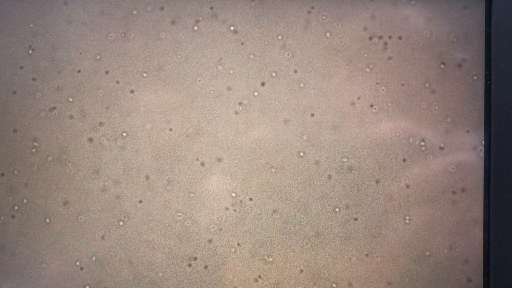

In [3]:
# Frames can be displayed two different ways:
#                                            1) frames[1]
#                                            2) plt.imshow(frames[1])
# Lets display the 0th frame to allow for the features of the frame to be located.
frames[0]

### Step 2. Locating Features

C:\Users\Turner\Anaconda3\lib\site-packages\trackpy\feature.py:349: UserWarning: I am interpreting the image as 3-dimensional. If it is actually a 2-dimensional color image, convert it to grayscale first.
  "convert it to grayscale first.".format(dim, dim-1))
C:\Users\Turner\Anaconda3\lib\site-packages\trackpy\find.py:133: UserWarning: All local maxima were in the margins.
  warnings.warn("All local maxima were in the margins.", UserWarning)


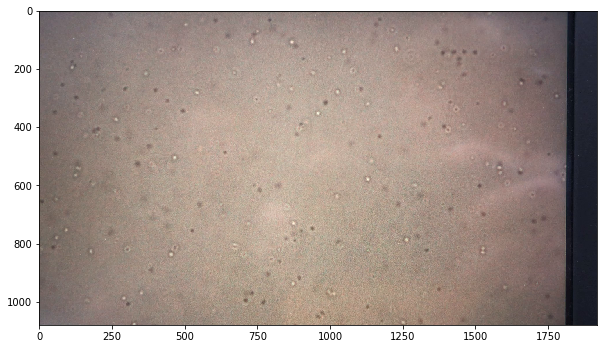

In [5]:
# Lets begin by looking at the first frame to determine the correct parameters before analyzing all images.

# tp.locate(frame number, particle size, invert colours, minmass)
# 
# The particle size must be an odd number and is the estimated number of pixels. It is better to overestimate.
#
# As trackpy looks for bright features the images colours may need to be inverted to allow for the tracking to occur.
#
# Minmass is the minimum mass of the particles (based on brightness) that will be tracked.
#

particleSize = 71
minimumMass = 400
f = tp.locate(frames[0], particleSize, invert=True, minmass = minimumMass)

# Plots the located particles to see if the above settings are appropriate.
plt.figure()
tp.annotate(f, frames[0])

In [ ]:
# After determining the correct settings for the particle location the locate command can be used on each frame.

# Commands for locating features in different numbers of frames can be seen below:
# All frames -> frames[:] or frames
# First 10 frames -> frames[:10]
# Last 10 frames -> frames{-10:}
# A range of frames -> frames[100:200]
# Every 10th frame -> frames[::10]
# Specific frames -> frames[[frame#1, frame#2, frame#3]]
#

f = tp.batch(frames[:], particleSize, minmass=minimumMass, invert=True);

### Step 3. Determining the particles movement between frames

In [ ]:
# Now that we have completed tracking of each frame the movement between frames needs to be completed.

# The following code looks within a certain range of each pixel and compares between frames to determine its trajectory while rememebering the location of lost particles for a certain amount of time.

maxPixelDistance = 20 # The max distance in pixels a particle can travel between frames.
particleMemory = 5 # How long a particle is remembered if its position becomes unknown between frames.
t = tp.link_df(f, maxPixelDistance, memory = particleMemory)

t.head() # Displays the first few lines of the analyzed data.

### Step 4. Filtering the data

In [ ]:
# We can now filter the data based on the number of frames that a particle exists for.

minNumberOfFrames = 10 # The min number of frames we wil consider.
t_adjusted = tp.filter_stubs(t, minNumberOfFrames)

# Lets state how many particles were tracked before filtering verse after filtering.
print('Before:', t['particle'].nunique())
print('After:', t_adjusted['particle'].nunique())

In [ ]:
# We can now remove the overall drifting motion observed.

# Determines the drift of the system.
drift = tp.compute_drift(t_adjusted) 

# Creates a new filtered data set with the drift removed.
t_filtered = tp.subtract_drift(t_adjusted.copy(), drift)


# Lets display a plot of the determined filtered trajectories.
plt.figure()
tp.plot_traj(t_filtered);

### Step 5. Determining the mean squared dispalcement of individual particles

In [ ]:
# Computing the individual mean squared displacement of each particle.

micronsPerPixel = 100/285.
framesPerSecond = 14
im = tp.imsd(t_filtered, micronsPerPixel, framesPerSecond)

fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
# Computing the ensembled mean squared displacement of each particle.

micronsPerPixel = 100/285.
framesPerSecond = 24
em = tp.emsd(t_filtered, micronsPerPixel, framesPerSecond)

fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-2, 10));

### Step 6. Performing a fit on the ensemble mean-square displacement

In [ ]:
# Performs a fit of the ensemble mean-squared displacement to a power law At^n.

plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # Performs linear best fit in log space, plots.